Mona Mokart

# Challenge IMA 205
## Classification of cell images
_____________________________________________________________
L'objectif de ce challenge est de trouver les meilleurs modèles possibles pour classer des images de cellules. Ce projet est composé de deux challenges : un challenge de classification binaire et un challenge de classification à classes multiples. Cela s'est fait via Kaggle.

Sommaire : 
- **I Importations**
- **II Modèles à partir des premières features**
    - *1. LDA*
    - *2. QDA*
    - *3. KNN*
    - *4. Linear SVM - Binary*
    - *5. Gaussian SVM - Binary*
        
- **III Modèles à partir des deuxièmes features**
    - *1. SVM (binary)*
    - *2. LDA (Multiclass)*
    - *3. SVM one vs rest (Multiclass)*
    - *4. Random Forest*
    - *5. AdaBoost*
    - *6. MLP*
- **IV Deep Learning**
    - *1. Test sur 5 modèles*
    - *2. Data augmentation*
- **V Autres méthodes**
    - *1. Deep features*
    - *2. Somme des meilleures predictions*
- **VI - Conclusion**

# <u>I - Importations </u>

In [136]:
import pandas as pd
import numpy as np
from skimage.io import imread
import cv2
import seaborn as sn
from skimage import measure
from skimage.measure import find_contours
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef as mcc, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
import warnings
from skimage.transform import resize

# import tensorflow models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers, Input
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19, Xception, ResNet50, MobileNet

from tensorflow.nn import sigmoid_cross_entropy_with_logits 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def plot_cm(y_test, y_pred):  # Pour afficher les matrices de confusions
    n_class = max(np.unique(y_test))+1
    labels = list(range(n_class))
    m = confusion_matrix(y_test, y_pred, labels=labels)
    m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(m, columns=labels, index=labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.heatmap(df_cm, annot=True, cmap="Reds")

In [3]:
Working_directory = "./" 
df_train = pd.read_csv(Working_directory + 'metadataTrain.csv')
df_test = pd.read_csv(Working_directory + 'SampleSubmission.csv')

In [4]:
# Importation des labels et leur ids
id_train = df_train["ID"].values
y_train = df_train["ABNORMAL"].values
y_train_bis = df_train["GROUP"].values
id_test = df_test["ID"].values

#  mettre dans l'ordre d'abord : 
order_id_train = np.argsort(id_train)
id_train = id_train[order_id_train]
y_train = y_train[order_id_train]
y_train_bis = y_train_bis[order_id_train]

id_test.sort()

In [5]:
# Importation des images de training
warnings.filterwarnings("ignore")

Images_train = []
Images_segCyt_train = []
Images_segNuc_train = []
for i in id_train :
    Images_train.append(imread(Working_directory+ "Train/Train/" + str(i)+".bmp"))
    Images_segCyt_train.append(imread(Working_directory+ "Train/Train/" + str(i)+"_segCyt.bmp"))
    Images_segNuc_train.append(imread(Working_directory+ "Train/Train/" + str(i)+"_segNuc.bmp"))
Images_train = np.array(Images_train)
Images_segCyt_train = np.array(Images_segCyt_train)
Images_segNuc_train = np.array(Images_segNuc_train)
N = Images_train.shape[0]

In [6]:
print('Number of train images: {0}'.format(N))
print('Number of normal cells: {0}; Number of abnormal cells: {1}'.format(N-np.sum(y_train), np.sum(y_train)))

Number of train images: 2921
Number of normal cells: 1302; Number of abnormal cells: 1619


In [7]:
# Importation des images de test
Images_test = []
Images_segCyt_test = []
Images_segNuc_test = []
for i in id_test :
    Images_test.append(imread(Working_directory+ "Test/Test/" + str(i)+".bmp"))
    Images_segCyt_test.append(imread(Working_directory+ "Test/Test/" + str(i)+"_segCyt.bmp"))
    Images_segNuc_test.append(imread(Working_directory+ "Test/Test/" + str(i)+"_segNuc.bmp"))
Images_test = np.array(Images_test)
Images_segCyt_test = np.array(Images_segCyt_test)
Images_segNuc_test = np.array(Images_segNuc_test)
M = Images_test.shape[0]

In [8]:
print('Number of test images: {0}'.format(M))

Number of test images: 1252


# <u>II - Modèles à partir des premières features</u>

**Creation des features**

In [9]:
# Functions pour extraires les features
def norm_grad(im):
    sobelx = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=5)
    return(sobelx**2 + sobely**2)**0.5





def features(im, segCyt, segNuc):
    features = []
    #  ratio and areas
    features.append(np.sum(segCyt))
    features.append(np.sum(segNuc))
    features.append(np.sum(segNuc)/np.sum(segCyt))
    
    
    if np.sum(segNuc)!=0:
        contours_Cyt = find_contours(segCyt,0.5)
        contours_Nuc = find_contours(segNuc,0.5)
        tension1 = np.gradient(contours_Cyt[0],axis=0)
        tension2 = np.gradient(contours_Nuc[0],axis=0)
        features.append(np.abs(tension1).mean())
        features.append(np.abs(tension2).mean())
    
        courbure1 = np.gradient(tension1,axis=0)
        courbure2 = np.gradient(tension2,axis=0)
        features.append(np.abs(courbure1).mean())
        features.append(np.abs(courbure2).mean())
    else : 
        features.append(0)
        features.append(0)
        features.append(0)
        features.append(0)
    
    
    for i in range(3):
        channel = cv2.equalizeHist(im[:,:,i])
        #  average intensity
        av_Cyt = (channel*segCyt).mean()
        av_Nuc = (channel*segNuc).mean()
        features.append(av_Cyt)
        features.append(av_Nuc)
        
        #  standard deviation 
        std_Cyt = (channel*segCyt).std()
        std_Nuc = (channel*segNuc).std()
        features.append(std_Cyt)
        features.append(std_Nuc)
        
        #  gradient
        grad_Cyt = norm_grad(channel*segCyt).mean()
        grad_Nuc = norm_grad(channel*segNuc).mean()
        features.append(grad_Cyt)
        features.append(grad_Nuc)
    return features

In [10]:
X_train = []
for i in range(N):
    X_train.append(features(Images_train[i],Images_segCyt_train[i],Images_segNuc_train[i]))

In [11]:
# Enregistrement des features dans un fichier csv pour gagner du temps
X_train = np.array(X_train)
pd.DataFrame(X_train).to_csv(Working_directory + "features_train.csv", index=None)

In [12]:
X_test = []
for i in range(M):
    X_test.append(features(Images_test[i],Images_segCyt_test[i],Images_segNuc_test[i]))

In [13]:
# Enregistrement des features 
X_test = np.array(X_test)
pd.DataFrame(X_test).to_csv(Working_directory + "features_test.csv", index=None)

______________________________________________________
**Entrainement**

In [14]:
# Importation des features
X_traindf = pd.read_csv(Working_directory + 'features_train.csv')
X_testdf = pd.read_csv(Working_directory + 'features_test.csv')

In [15]:
X_train = X_traindf[X_traindf.columns[:]].values
X_test = X_testdf[X_testdf.columns[:]].values

In [16]:
# Suffle data

i = np.random.randint(100)
np.random.seed(i)
Xp = np.random.permutation(X_train)

np.random.seed(i)
yp = np.random.permutation(y_train)

np.random.seed(i)
yp_bis = np.random.permutation(y_train_bis)

np.random.seed(i)
idsp = np.random.permutation(id_train)

In [17]:
# Normalize data
normalizer = MinMaxScaler()
normalizer.fit(Xp)
X_train_n = normalizer.transform(Xp)
X_test_n = normalizer.transform(X_test)

In [18]:
scores = pd.DataFrame(index = ["Train", "Test"])
scores_bis = pd.DataFrame(index = ["Train", "Test"])

## II.1 - LDA

### Classification binaire

In [19]:
# LDA - Binary
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_n, yp)
y_pred_lda = lda.predict(X_test_n)
dt = time() - t0
train_score_LDA = mcc(lda.predict(X_train_n), yp)

print("Time of computation :", dt)
print("Accuracy score on the training set :", lda.score(X_train_n, yp))
print("MCC score on the training set :", mcc(lda.predict(X_train_n), yp))


submission_lda = pd.DataFrame()
submission_lda["ID"] = id_test
submission_lda["ABNORMAL"] = y_pred_lda
submission_lda.to_csv(Working_directory + "submission_lda.csv", index=False)

Time of computation : 0.0898740291595459
Accuracy score on the training set : 0.8986648408079425
MCC score on the training set : 0.7982827872036355


Résultat : 0.77781 (private score)

In [20]:
scores["LDA"] = [train_score_LDA, 0.77781]

### Classification en 9 classes

In [23]:
#LDA - multiclass classification
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_n, yp_bis)
y_pred_lda_bis = lda.predict(X_test_n)
dt = time() - t0
train_score_LDA_bis = f1_score(lda.predict(X_train_n), yp_bis, average="macro")

print("Time of computation :", dt)
print("accuracy score on the training set :", lda.score(X_train_n, yp_bis))
print("f1 score on the training set :", train_score_LDA_bis)

submission_lda_bis = pd.DataFrame()
submission_lda_bis["ID"] = id_test
submission_lda_bis["GROUP"] = y_pred_lda_bis
submission_lda_bis.to_csv(Working_directory + "submission_lda_bis.csv", index=False)

Time of computation : 0.026674985885620117
accuracy score on the training set : 0.8206093803491955
f1 score on the training set : 0.6806761057018837


Résultat : 0.59987

In [24]:
scores_bis["LDA"] = [train_score_LDA_bis, 0.59987]

## II.2 - QDA

### Classification binaire

In [26]:
# QDA - Binary
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_n, yp)
y_pred_qda = qda.predict(X_test_n)
dt = time() - t0
train_score_QDA = mcc(qda.predict(X_train_n), yp)

print("Time of computation :", dt)
print("Accuracy score on the train set :",qda.score(X_train_n,yp))
print("mcc score on the train set :", train_score_QDA)

submission_qda = pd.DataFrame()
submission_qda["ID"] = id_test
submission_qda["ABNORMAL"] = y_pred_qda
submission_qda.to_csv(Working_directory + "submission_qda.csv",index=False)

Time of computation : 0.008731842041015625
Accuracy score on the train set : 0.845258473125642
mcc score on the train set : 0.6967986218474556


Résultat : 0.65339

In [27]:
scores["QDA"] = [train_score_QDA, 0.65339]

### Classification en 9 classes

In [28]:
# QDA - Multiclass
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_n, yp_bis)
y_pred_qda_bis = qda.predict(X_test_n)
dt= time() - t0
train_score_QDA_bis = f1_score(qda.predict(X_train_n), yp_bis, average="macro")

print("Time of computation :", dt)
print("Accuracy score on the train set :",qda.score(X_train_n, yp_bis))
print("f1 score on the train set :", train_score_QDA_bis)

submission_qda_bis = pd.DataFrame()
submission_qda_bis["ID"] = id_test
submission_qda_bis["GROUP"] = y_pred_qda_bis
submission_qda_bis.to_csv(Working_directory + "submission_qda_bis.csv",index=False)

Time of computation : 0.027808189392089844
Accuracy score on the train set : 0.7939061965080452
f1 score on the train set : 0.7270935067310862


Résultat : 0.51379

In [29]:
scores_bis["QDA"] = [train_score_QDA_bis, 0.51379]

## II.3 - KNN

### Classification binaire

In [30]:
#KNN - cross validation 
t0 = time()
class_names = ["abnormal","normal"]
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train_n, yp)
y_pred_KNN = grid_KNN.predict(X_test_n)
dt = time() - t0
train_score_KNN = mcc(grid_KNN.predict(X_train_n), yp)

print("Time of computation :", dt)
print("Best training params: {}".format(grid_KNN.best_params_))
print("Accuracy score on the train set :", grid_KNN.score(X_train_n,yp))
print("mcc score on the train set :", train_score_KNN)

submission_KNN = pd.DataFrame()
submission_KNN["ID"] = id_test
submission_KNN["ABNORMAL"] = y_pred_KNN
submission_KNN.to_csv(Working_directory + "submission_KNN.csv",index=False)

Time of computation : 4.345381259918213
Best training params: {'n_neighbors': 9}
Accuracy score on the train set : 0.9226292365628209
mcc score on the train set : 0.8434403859445926


Résultat : 0.73830

In [31]:
scores["KNN"] = [train_score_KNN, 0.73830]

### Classification en 9 classes


In [47]:
#  KNN - cross validation 
t0 = time()
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train_n, yp_bis)
y_pred_KNN_bis = grid_KNN.predict(X_test_n)
dt = time() - t0
train_score_KNN_bis = f1_score(grid_KNN.predict(X_train_n), yp_bis, average="macro")

print("Time of computation :", dt)
print("Best training params: {}".format(grid_KNN.best_params_))
print("Accuracy score on the train set :", grid_KNN.score(X_train_n, yp_bis))
print("f1 score on the train set :", train_score_KNN_bis)


submission_KNN_bis = pd.DataFrame()
submission_KNN_bis["ID"] = id_test
submission_KNN_bis["GROUP"] = y_pred_KNN_bis
submission_KNN_bis.to_csv(Working_directory + "submission_KNN_bis.csv",index=False)

Time of computation : 5.322679281234741
Best training params: {'n_neighbors': 5}
Accuracy score on the train set : 0.8034919548099966
f1 score on the train set : 0.7069525454329894


Résultat : 0.51379

In [33]:
scores_bis["KNN"] = [train_score_KNN_bis, 0.51379]

## II.4 - Linear SVM : binary

In [34]:
t0 = time()
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = SVC(kernel='linear')
grid_lsvm = GridSearchCV(estimator= Lsvm,param_grid=p_grid_lsvm, scoring='f1', cv=5)
grid_lsvm.fit(X_train_n, yp)
y_pred_lsvm = grid_lsvm.predict(X_test_n)
dt = time() - t0
train_score_LSVM = mcc(grid_lsvm.predict(X_train_n), yp)

print("Time of computation :", dt)
print("Best training params: {}".format(grid_lsvm.best_params_))
print("Accuracy score on the train set :", grid_lsvm.score(X_train_n, yp))
print("mcc score on the train set :", train_score_LSVM)


submission_lsvm = pd.DataFrame()
submission_lsvm["ID"] = id_test
submission_lsvm["ABNORMAL"] = y_pred_lsvm
submission_lsvm.to_csv(Working_directory + "submission_lsvm.csv",index=False)

Time of computation : 16.03715419769287
Best training params: {'C': 10.0}
Accuracy score on the train set : 0.9301219149568838
mcc score on the train set : 0.8388458215675472


Résultat  :  0.75663

In [35]:
scores["LSVM"] = [train_score_LSVM, 0.75663]

## II.5 - NLSVM : binary

In [37]:
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, scoring='accuracy', cv=5 )
grid_nlsvm.fit(X_train_n, yp)
y_pred_nlsvm = grid_nlsvm.predict(X_test_n)
dt = time() - t0
train_score_NLSVM = mcc(grid_nlsvm.predict(X_train_n), yp)

print("Time of computation :", dt)
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("Accuracy score on the train set :", grid_nlsvm.score(X_train_n, yp))
print("mcc score on the train set :", train_score_NLSVM)

submission_nlsvm = pd.DataFrame()
submission_nlsvm["ID"] = id_test
submission_nlsvm["ABNORMAL"] = y_pred_nlsvm
submission_nlsvm.to_csv(Working_directory + "submission_nlsvm2.csv",index=False)

Time of computation : 257.9193985462189
Best training params: {'C': 10.0, 'gamma': 0.1}
Accuracy score on the train set : 0.9202327969873331
mcc score on the train set : 0.8426738461648732


Résultat : 0.81023

In [38]:
scores["NLSVM"] = [train_score_NLSVM, 0.81023]

______________________________________________________________________________________________________________
 **Mini conclu**:
 
Finalement ici les meilleures techniques semblent être LDA pour la multiclass et NLSVM pour la binary class classification
Je viens de tester certains algorithmes sur des features imples afin de me faire une idée de ce qui fonctionne bien, maintentant il faut améliorer les résultats.

Il faudrait tester la prédition de l'algorithme avec des méthodes d'ensemble, cela pourrait réduire la variance et peut-être l'overfitting.

De plus, jusqu'ici on n'avait pas de vue sur ce que l'on faisait car on n'a pas accès aux classifications du testset, ainsi par la suite on va séparer le trainset en un mini trainset et un mini testset pour voir le comportement des prédictions surtout pour la classification binaire afin de determiner si il y a des biais (faux positifs et faux negatifs). J'utiliserais alors les scores recommandés :  Matthews correlation coefficient et Weighted Categorization Accuracy pour la cross validation.

Enfin, ici les features peuvent être améliorées, c'est que je vais faire, mais toujours sans résaux de neurones.
______________________________________________________________________________________________________________

# <u>III - Modèles à partir des deuxièmes features</u>
**Creation des features**

In [39]:
from skimage.measure import regionprops


def norm_grad(im):
    sobelx = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=5)
    return(sobelx**2 + sobely**2)**0.5



def features2(im, segCyt, segNuc):
    sumN = np.sum(segNuc)
    features = []
    #  ratio and areas
    features.append(np.sum(segCyt))
    features.append(np.sum(segNuc))
    features.append(np.sum(segNuc)/np.sum(segCyt))
    
    # relative position
    cCyt = regionprops(segCyt)[0].centroid
    if sumN!=0:
        cNuc = regionprops(segNuc)[0].centroid
    else:
        cNuc = (0,0)
    features.append(cCyt[0]-cNuc[0])  # decalage en x
    features.append(cCyt[1]-cNuc[1])  # decalage en y
    
    # eccentricity
    features.append(regionprops(segCyt)[0].eccentricity)
    if sumN !=0:
        features.append(regionprops(segNuc)[0].eccentricity)
    else :
        features.append(0)
    
    # major_axis_length
    features.append(regionprops(segCyt)[0].major_axis_length)
    if sumN !=0:
        features.append(regionprops(segNuc)[0].major_axis_length)
    else :
        features.append(0)
    
    # minor_axis_length
    features.append(regionprops(segCyt)[0].minor_axis_length)
    if sumN !=0:
        features.append(regionprops(segNuc)[0].minor_axis_length)
    else :
        features.append(0)
    
    # perimeter
    features.append(regionprops(segCyt)[0].perimeter)
    if sumN !=0:
        features.append(regionprops(segNuc)[0].perimeter)
    else :
        features.append(0)
    
    # orientation
    features.append(regionprops(segCyt)[0].orientation)
    if sumN !=0:
        features.append(regionprops(segNuc)[0].orientation)
    else :
        features.append(0)
    
    if sumN !=0:
        contours_Cyt = find_contours(segCyt,0.5)
        contours_Nuc = find_contours(segNuc,0.5)
        tension1 = np.gradient(contours_Cyt[0],axis=0)
        tension2 = np.gradient(contours_Nuc[0],axis=0)
        features.append(np.abs(tension1).mean())
        features.append(np.abs(tension2).mean())
    
        courbure1 = np.gradient(tension1,axis=0)
        courbure2 = np.gradient(tension2,axis=0)
        features.append(np.abs(courbure1).mean())
        features.append(np.abs(courbure2).mean())
    else : 
        features.append(0)
        features.append(0)
        features.append(0)
        features.append(0)
    
    
    for i in range(3):
        channel = cv2.equalizeHist(im[:,:,i])
        # average intensity
        av_Cyt = (channel*segCyt).mean()
        av_Nuc = (channel*segNuc).mean()
        features.append(av_Cyt)
        features.append(av_Nuc)
        
        # standard deviation 
        std_Cyt = (channel*segCyt).std()
        std_Nuc = (channel*segNuc).std()
        features.append(std_Cyt)
        features.append(std_Nuc)
        
        # gradient
        grad_Cyt = norm_grad(channel*segCyt).mean()
        grad_Nuc = norm_grad(channel*segNuc).mean()
        features.append(grad_Cyt)
        features.append(grad_Nuc)
        
        # max and min intensity
        features.append(np.max(channel*segCyt))
        features.append(np.max(channel*segNuc))
        features.append(np.min(channel*segCyt))
        features.append(np.min(channel*segNuc))
        
        
    return features

In [40]:
X_train2 = []
for i in range(N):
    X_train2.append(features2(Images_train[i],Images_segCyt_train[i],Images_segNuc_train[i]))

In [41]:
X_train2 = np.array(X_train2)
pd.DataFrame(X_train2).to_csv(Working_directory + "features_train2.csv", index=None)

In [42]:
X_test2 = []
for i in range(M):
    X_test2.append(features2(Images_test[i],Images_segCyt_test[i],Images_segNuc_test[i]))

In [43]:
X_test2 = np.array(X_test2)
pd.DataFrame(X_test2).to_csv(Working_directory + "features_test2.csv", index=None)

_____________________________________
**Entrainement**


In [44]:
# Import data
X_traindf = pd.read_csv(Working_directory + 'features_train2.csv')
X_testdf = pd.read_csv(Working_directory + 'features_test2.csv')

X_train = X_traindf[X_traindf.columns[:]].values
X_test = X_testdf[X_testdf.columns[:]].values

In [45]:
# Suffle data

i=np.random.randint(100)
np.random.seed(i)
Xp=np.random.permutation(X_train)

np.random.seed(i)
yp=np.random.permutation(y_train)

np.random.seed(i)
yp_bis=np.random.permutation(y_train_bis)

np.random.seed(i)
idsp=np.random.permutation(id_train)


# Normalize data
normalizer2 = MinMaxScaler()
normalizer2.fit(Xp)
X_train_n = normalizer2.transform(Xp)
X_test_n = normalizer2.transform(X_test)

In [46]:
# split mini trainset min testset

miniX_train, miniX_test, my_train, my_test = train_test_split(Xp, yp, test_size=0.2)
miniX_train_bis, miniX_test_bis, my_train_bis, my_test_bis = train_test_split(Xp, yp_bis, test_size=0.2)

mininormalizer = MinMaxScaler()
mininormalizer.fit(miniX_train)
mX_train = mininormalizer.transform(miniX_train)
mX_test = mininormalizer.transform(miniX_test)

mininormalizer = MinMaxScaler()
mininormalizer.fit(miniX_train_bis)
mX_train_bis = mininormalizer.transform(miniX_train_bis)
mX_test_bis = mininormalizer.transform(miniX_test_bis)

## III.1 - NLSVM

Best mini training params: {'C': 10, 'gamma': 1}
Mini training mcc score : 0.9609612620770825
Mini testing mcc score : 0.9179288771965108


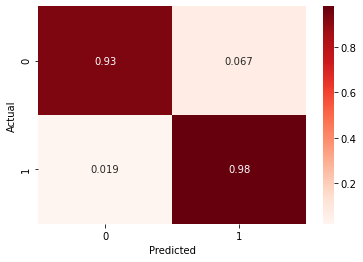

In [48]:
warnings.filterwarnings("ignore")

p_grid_nlsvm = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, scoring=make_scorer(mcc), cv=5 )
grid_nlsvm.fit(mX_train, my_train)
my_pred_nlsvm = grid_nlsvm.predict(mX_test)


print("Best mini training params: {}".format(grid_nlsvm.best_params_))
print("Mini training mcc score :", mcc(grid_nlsvm.predict(mX_train), my_train))
print("Mini testing mcc score :", mcc(grid_nlsvm.predict(mX_test), my_test))


plot_cm(my_test, my_pred_nlsvm)

In [50]:
NLsvm = SVC(kernel='rbf', C=grid_nlsvm.best_params_["C"], gamma=grid_nlsvm.best_params_["gamma"])
NLsvm.fit(X_train_n, yp)
train_score_nlsvm2 = mcc(NLsvm.predict(X_train_n), yp)

print("Mcc training score :", train_score_nlsvm2)
y_pred_nlsvm = NLsvm.predict(X_test_n)

submission_nlsvm = pd.DataFrame()
submission_nlsvm["ID"] = id_test
submission_nlsvm["ABNORMAL"] = y_pred_nlsvm
submission_nlsvm.to_csv(Working_directory + "submission_nlsvm2.csv",index=False)

Mcc training score : 0.9653748762127792


Résultat : 0.80884

In [51]:
scores["NLSVM2"] = [train_score_nlsvm2, 0.80884]

## III.2 - LDA - Multiclass classification

Mini training f1 score : 0.7248802056575379
Mini testing f1 score : 0.6957147036642779


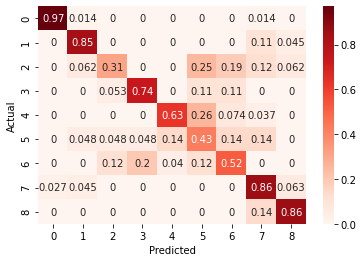

In [55]:
lda = LinearDiscriminantAnalysis()
lda.fit(mX_train_bis, my_train_bis)
my_pred_lda_bis = lda.predict(mX_test_bis)

print("Mini training f1 score :", f1_score(lda.predict(mX_train_bis), my_train_bis, average="macro"))
print("Mini testing f1 score :", f1_score(lda.predict(mX_test_bis), my_test_bis, average="macro"))


plot_cm(my_test_bis, my_pred_lda_bis)

In [56]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_n, yp_bis)
train_score_lda_bis2 = f1_score(lda.predict(X_train_n),yp_bis,average="macro")

print("f1 training score :", train_score_lda_bis2)

y_pred_lda_bis = lda.predict(X_test_n)
submission_lda_bis = pd.DataFrame()
submission_lda_bis["ID"] = id_test
submission_lda_bis["GROUP"] = y_pred_lda_bis
submission_lda_bis.to_csv(Working_directory + "submission_lda2_bis.csv", index=False)

f1 training score : 0.7239981636634982


Résultat : 0.70684

In [57]:
scores_bis["LDA2"] = [train_score_lda_bis2, 0.70684]

## III.3 - NLSVM One versus rest - Multiclass classification

Mini training f1 score : 0.8581321339811738
Mini testing f1 score : 0.7182312003765675


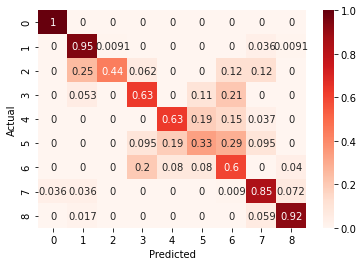

In [59]:
p_grid_ovr = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], }

OVR = SVC(kernel='rbf', decision_function_shape='ovr')
grid_ovr = GridSearchCV(estimator= OVR, param_grid=p_grid_ovr, scoring="f1_weighted", cv=5)
grid_ovr.fit(mX_train_bis, my_train_bis)
my_pred_ovr = grid_ovr.predict(mX_test_bis)

print("Mini training f1 score :", f1_score(grid_ovr.predict(mX_train_bis), my_train_bis, average="macro"))
print("Mini testing f1 score :", f1_score(grid_ovr.predict(mX_test_bis), my_test_bis, average="macro"))

my_pred_ovr = grid_ovr.predict(mX_test_bis)

plot_cm(my_test_bis, my_pred_ovr)

In [60]:
OVR = SVC(kernel='rbf', decision_function_shape='ovr', C=grid_ovr.best_params_["C"], gamma=grid_ovr.best_params_["gamma"])
OVR.fit(X_train_n, yp_bis)
train_score_ovr_bis2 = f1_score(OVR.predict(X_train_n), yp_bis,average="macro")

print("F1 training score :", train_score_ovr_bis2)

y_pred_ovr = OVR.predict(X_test_n)
submission_ovr = pd.DataFrame()
submission_ovr["ID"] = id_test
submission_ovr["GROUP"] = y_pred_ovr
submission_ovr.to_csv(Working_directory + "submission_ovr2.csv",index=False)

F1 training score : 0.837680426239618


Résultat : 0.69823

In [61]:
scores_bis["SVM_OvR_2"] = [train_score_ovr_bis2, 0.69823]

## III.4 - Random Forest

### Binary classification

Mini best training params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Mini training score : 0.9973968435901831
Mini testing score : 0.885762243386165


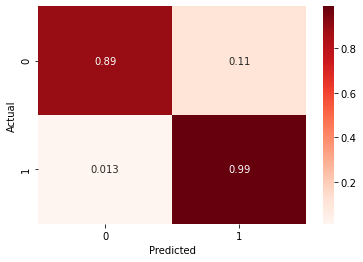

In [65]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
p_grid_RF = {'n_estimators': [10,20,30,50, 100, 150], 'min_samples_leaf': [2,3,4,5,6,7,8,9,10], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring=make_scorer(mcc), cv=5)
grid_RF.fit(mX_train, my_train)
my_pred_RF = grid_RF.predict(mX_test)


print("Mini best training params: {}".format(grid_RF.best_params_))
print("Mini training score :", mcc(grid_RF.predict(mX_train), my_train))
print("Mini testing score :", mcc(my_pred_RF, my_test))



plot_cm(my_test, my_pred_RF)

In [66]:
max_features = grid_RF.best_params_["max_features"]
min_samples_leaf = grid_RF.best_params_["min_samples_leaf"]
n_estimators = grid_RF.best_params_["n_estimators"]

RF = RandomForestClassifier(max_features=max_features, min_samples_leaf=min_samples_leaf,
                            n_estimators=n_estimators) 
RF.fit(X_train_n, yp)
train_score_RF2 = mcc(RF.predict(X_train_n), yp)

print("Mcc training score :", train_score_RF2)


y_pred_RF = RF.predict(X_test_n)
submission_RF = pd.DataFrame()
submission_RF["ID"] = id_test
submission_RF["ABNORMAL"] = y_pred_RF
submission_RF.to_csv(Working_directory + "submission_RF2.csv",index=False)

Mcc training score : 0.9930768897312089


In [71]:
scores["RF2"] = [train_score_RF2, 0.80121]

Résultat :0.80121

### Multi class

Best mini training params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}
Mini training f1 score : 0.9973558028369615
Mini testing f1 score : 0.6846193106558355


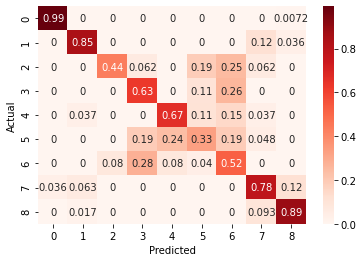

In [68]:
RF = RandomForestClassifier()
p_grid_RF2 = {'n_estimators': [10,20,30,50, 100, 150], 'min_samples_leaf': [2,3,4,5,6,7,8,9,10],
              'max_features': ['sqrt','log2']}   

grid_RF2 = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1_weighted", cv=5)
grid_RF2.fit(mX_train_bis, my_train_bis)
my_pred_RF2 = grid_RF2.predict(mX_test_bis)

print("Best mini training params: {}".format(grid_RF2.best_params_))
print("Mini training f1 score :", f1_score(grid_RF2.predict(mX_train_bis), my_train_bis, average="macro"))
print("Mini testing f1 score :", f1_score(grid_RF2.predict(mX_test_bis), my_test_bis, average="macro"))

plot_cm(my_test_bis, my_pred_RF2)

In [69]:
max_features2 = grid_RF2.best_params_["max_features"]
min_samples_leaf2 = grid_RF2.best_params_["min_samples_leaf"]
n_estimators2 = grid_RF2.best_params_["n_estimators"]

RF = RandomForestClassifier(max_features=max_features2, min_samples_leaf=min_samples_leaf2,
                            n_estimators=n_estimators2) 
RF.fit(X_train_n, yp_bis)
y_pred_RF_bis = RF.predict(X_test_n)
train_score_RF_bis2 = f1_score(RF.predict(X_train_n), yp_bis, average="macro")

print("F1 training score :", train_score_RF_bis2)

submission_RF_bis = pd.DataFrame()
submission_RF_bis["ID"] = id_test
submission_RF_bis["GROUP"] = y_pred_RF_bis
submission_RF_bis.to_csv(Working_directory + "submission_RF2_bis.csv",index=False)

F1 training score : 0.9976792140272678


Résultat : 0.67171

In [72]:
scores_bis["RF2"] = [train_score_RF_bis2, 0.67171]

## III.5 - Ada Boost
### Binary classification

Mini best training params: {'n_estimators': 200}
Mini training score : 0.9558592334571093
Mini testing score : 0.8416303304743032


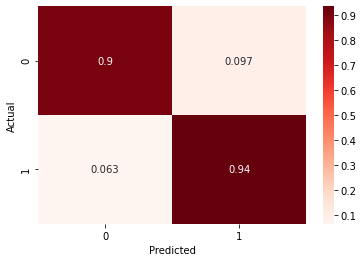

In [76]:
Ada = AdaBoostClassifier()
p_grid_Ada = {'n_estimators': [20, 30, 50, 100, 150, 200]}   
grid_Ada = GridSearchCV(estimator=Ada, param_grid=p_grid_Ada, scoring=make_scorer(mcc), cv=5)
grid_Ada.fit(mX_train, my_train)
my_pred_Ada = grid_Ada.predict(mX_test)


print("Mini best training params: {}".format(grid_Ada.best_params_))
print("Mini training score :", mcc(grid_Ada.predict(mX_train), my_train))
print("Mini testing score :", mcc(my_pred_Ada, my_test))


plot_cm(my_test, my_pred_Ada)

In [77]:
Ada = AdaBoostClassifier(n_estimators=grid_Ada.best_params_["n_estimators"]) 
Ada.fit(X_train_n, yp)
y_pred_ada = Ada.predict(X_test_n)


train_score_ada2 = mcc(Ada.predict(X_train_n), yp)

print("Mcc training score :", train_score_ada2)

submission_ada = pd.DataFrame()
submission_ada["ID"] = id_test
submission_ada["ABNORMAL"] = y_pred_ada
submission_ada.to_csv(Working_directory + "submission_Ada_cv2.2csv",index=False)

Mcc training score : 0.9397984073235843


Résultat : 0.78634

In [78]:
scores["AdaBoost2"] = [train_score_ada2, 0.78634]

### Multiclass

Best mini validation score: 0.36929134167120814
Best mini training params: {'n_estimators': 100}
Mini testing score : 0.34640844748898864


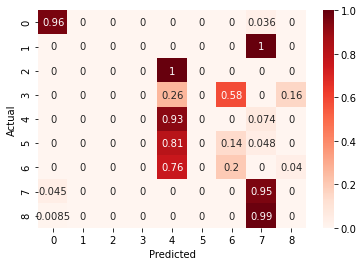

In [79]:
Ada = AdaBoostClassifier()
p_grid_Ada_bis = {'n_estimators': [20, 30, 50, 100, 150, 200]}   
grid_Ada_bis = GridSearchCV(estimator=Ada, param_grid=p_grid_Ada_bis, scoring="f1_weighted", cv=5)
grid_Ada_bis.fit(mX_train_bis, my_train_bis)
print("Best mini validation score: {}".format(grid_Ada_bis.best_score_))
print("Best mini training params: {}".format(grid_Ada_bis.best_params_))
print("Mini testing score :", grid_Ada_bis.score(mX_test_bis, my_test_bis))
my_pred_Ada_bis = grid_Ada_bis.predict(mX_test_bis)

plot_cm(my_test_bis, my_pred_Ada_bis)

_____________________________________________________
## III.6 - MLP sur les features 
### Binary

In [82]:
n_input = X_train_n.shape[1]  
n_hidden1 = 200
n_hidden2 = 200
n_hidden3 = 100
n_hidden4 = 100


model_mlp = Sequential([Dense(n_hidden1, input_shape=(n_input,)),
                        BatchNormalization(),
                        Activation('relu'),
                        Dense(n_hidden2, input_shape=(n_hidden1,)),
                        BatchNormalization(),
                        Activation('relu'),
                        Dense(n_hidden3, input_shape=(n_hidden2,)),
                        BatchNormalization(),
                        Activation('relu'),
                        Dense(1, input_shape=(n_hidden3,)),
                        BatchNormalization(),
                        Activation('sigmoid')]) 


learning_rate = 0.001
model_mlp.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) 
n_epochs = 30
batch_size = 100

print('Training')
history = model_mlp.fit(X_train_n, yp, epochs=n_epochs, batch_size=batch_size, verbose=2)
y_pred_mlp = (model_mlp.predict(X_test_n) > 0.5).astype("int32")

submission_mlp = pd.DataFrame()
submission_mlp["ID"] = id_test
submission_mlp["ABNORMAL"] = y_pred_mlp
submission_mlp.to_csv(Working_directory + "submission_mlp.csv",index=False)

Training
Epoch 1/30
30/30 - 3s - loss: 0.4782 - accuracy: 0.8107
Epoch 2/30
30/30 - 0s - loss: 0.4061 - accuracy: 0.8881
Epoch 3/30
30/30 - 0s - loss: 0.3688 - accuracy: 0.9295
Epoch 4/30
30/30 - 0s - loss: 0.3469 - accuracy: 0.9486
Epoch 5/30
30/30 - 0s - loss: 0.3376 - accuracy: 0.9493
Epoch 6/30
30/30 - 0s - loss: 0.3213 - accuracy: 0.9599
Epoch 7/30
30/30 - 0s - loss: 0.3140 - accuracy: 0.9610
Epoch 8/30
30/30 - 0s - loss: 0.3013 - accuracy: 0.9675
Epoch 9/30
30/30 - 0s - loss: 0.2887 - accuracy: 0.9750
Epoch 10/30
30/30 - 0s - loss: 0.2803 - accuracy: 0.9767
Epoch 11/30
30/30 - 0s - loss: 0.2755 - accuracy: 0.9754
Epoch 12/30
30/30 - 0s - loss: 0.2635 - accuracy: 0.9843
Epoch 13/30
30/30 - 0s - loss: 0.2571 - accuracy: 0.9832
Epoch 14/30
30/30 - 0s - loss: 0.2561 - accuracy: 0.9819
Epoch 15/30
30/30 - 0s - loss: 0.2446 - accuracy: 0.9849
Epoch 16/30
30/30 - 0s - loss: 0.2352 - accuracy: 0.9890
Epoch 17/30
30/30 - 0s - loss: 0.2288 - accuracy: 0.9914
Epoch 18/30
30/30 - 0s - loss: 

Résultat : 0.84677

In [89]:
scores["MLP"] = [history.history['accuracy'][-1], 0.84677]

### Multiclass

In [93]:
n_input = X_train_n.shape[1]  # Number of input features
n_hidden1 = 200
n_hidden2 = 200
n_hidden3 = 200 # Number of hidden nodes

model_mlp_bis = Sequential([Dense(n_hidden1, input_shape=(n_input,)),
                        BatchNormalization(),
                        Activation('relu'),
                        Dense(n_hidden2, input_shape=(n_hidden1,)),
                        BatchNormalization(),
                        Activation('relu'),
                        Dense(n_hidden3, input_shape=(n_hidden2,)),
                        BatchNormalization(),
                        Activation('relu'),
                        Dense(9, input_shape=(n_hidden3,)),
                        BatchNormalization(),
                        Activation('softmax')]) 

# create the loss and optimiser
learning_rate = 0.001
model_mlp_bis.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) # TO FILL IN
# Run optimisation algorithm
n_epochs = 150
batch_size = 100

print('Training')
history = model_mlp_bis.fit(X_train_n, yp_bis, epochs=n_epochs, batch_size=batch_size, verbose=2)
y_pred_mlp_bis = model_mlp_bis.predict_classes(X_test_n)
submission_mlp_bis = pd.DataFrame()
submission_mlp_bis["ID"] = id_test
submission_mlp_bis["GROUP"] = y_pred_mlp_bis

submission_mlp_bis.to_csv(Working_directory + "submission_mlp_bis.csv",index=False)

Training
Epoch 1/150
30/30 - 3s - loss: 1.3445 - accuracy: 0.6197
Epoch 2/150
30/30 - 0s - loss: 0.9543 - accuracy: 0.7912
Epoch 3/150
30/30 - 0s - loss: 0.8422 - accuracy: 0.8288
Epoch 4/150
30/30 - 0s - loss: 0.7830 - accuracy: 0.8381
Epoch 5/150
30/30 - 0s - loss: 0.7272 - accuracy: 0.8579
Epoch 6/150
30/30 - 0s - loss: 0.6711 - accuracy: 0.8720
Epoch 7/150
30/30 - 0s - loss: 0.6359 - accuracy: 0.8857
Epoch 8/150
30/30 - 0s - loss: 0.6050 - accuracy: 0.8884
Epoch 9/150
30/30 - 0s - loss: 0.5652 - accuracy: 0.8980
Epoch 10/150
30/30 - 0s - loss: 0.5466 - accuracy: 0.9038
Epoch 11/150
30/30 - 0s - loss: 0.5044 - accuracy: 0.9161
Epoch 12/150
30/30 - 0s - loss: 0.4859 - accuracy: 0.9178
Epoch 13/150
30/30 - 0s - loss: 0.4797 - accuracy: 0.9089
Epoch 14/150
30/30 - 0s - loss: 0.4296 - accuracy: 0.9281
Epoch 15/150
30/30 - 0s - loss: 0.4129 - accuracy: 0.9332
Epoch 16/150
30/30 - 0s - loss: 0.3809 - accuracy: 0.9370
Epoch 17/150
30/30 - 0s - loss: 0.3665 - accuracy: 0.9415
Epoch 18/150
3

Epoch 142/150
30/30 - 0s - loss: 0.0390 - accuracy: 0.9942
Epoch 143/150
30/30 - 0s - loss: 0.0337 - accuracy: 0.9952
Epoch 144/150
30/30 - 0s - loss: 0.0381 - accuracy: 0.9949
Epoch 145/150
30/30 - 0s - loss: 0.0473 - accuracy: 0.9908
Epoch 146/150
30/30 - 0s - loss: 0.0251 - accuracy: 0.9983
Epoch 147/150
30/30 - 0s - loss: 0.0245 - accuracy: 0.9969
Epoch 148/150
30/30 - 0s - loss: 0.0360 - accuracy: 0.9942
Epoch 149/150
30/30 - 0s - loss: 0.0507 - accuracy: 0.9897
Epoch 150/150
30/30 - 0s - loss: 0.0316 - accuracy: 0.9959


Résultat : 0.66870

In [94]:
scores_bis["MLP"] = [history.history['accuracy'][-1], 0.66870]

### MLP sans overfitting

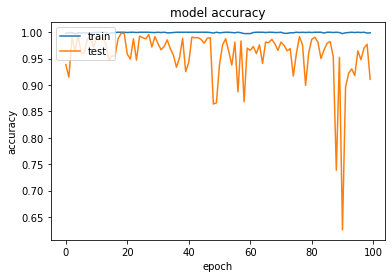

In [63]:
history = model_mlp.fit(X_train_n, to_categorical(yp), validation_split=0.33, epochs=100, batch_size=batch_size, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Nouveau MLP model**

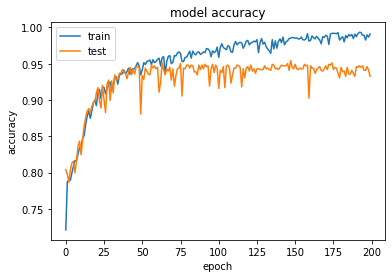

In [90]:
n_input = X_train_n.shape[1]  # Number of input features
n_hidden = 250
n_hidden2 = 100
# Number of hidden nodes

# create the model (using the sequential API)

model_mlp2 = Sequential([Dense(n_hidden, input_shape=(n_input,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(n_hidden2, input_shape=(n_hidden2,)),
                        Activation('relu'),
                        Dense(n_hidden2, input_shape=(n_hidden2,)),
                        Activation('relu'),
                        Dense(1, input_shape=(n_hidden2,)),
                        Activation('sigmoid')])

learning_rate = 0.0001
model_mlp2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) # TO FILL IN
batch_size = 60

history = model_mlp2.fit(X_train_n, to_categorical(yp), validation_split=0.33, epochs=200, batch_size=batch_size, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
model_mlp2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) # TO FILL IN
# Run optimisation algorithm
n_epochs = 100
batch_size = 60

print('Training')
model_mlp.fit(X_train_n, yp, epochs=n_epochs, batch_size=batch_size, verbose=0)
y_pred_mlp = (model_mlp.predict(X_test_n) > 0.5).astype("int32")

train_score_mlp2 = mcc((model_mlp.predict(X_train_n) > 0.5).astype("int32"), yp)
print("Mcc training score :", train_score_mlp2)

submission_mlp = pd.DataFrame()
submission_mlp["ID"] = id_test
submission_mlp["ABNORMAL"] = y_pred_mlp
submission_mlp.to_csv(Working_directory + "submission_mlp2.csv",index=False)

Training
Mcc training score : 0.9556694878784913


In [92]:
scores["MLP2"] = [train_score_mlp2, 0.84635]

Résultat : 0.84635

### Multiclass

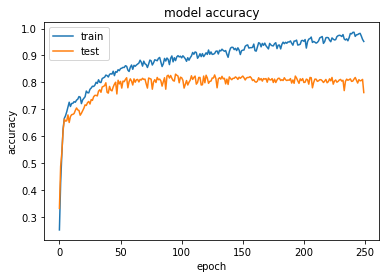

In [95]:
n_input = X_train_n.shape[1]  # Number of input features
n_hidden = 200
 # Number of hidden nodes

# create the model (using the sequential API)

model_mlp_bis2 = Sequential([Dense(n_hidden, input_shape=(n_input,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        Dense(9, input_shape=(n_hidden,)),
                        Activation('softmax')])

learning_rate = 0.0003
model_mlp_bis2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) # TO FILL IN
batch_size = 80

history = model_mlp_bis2.fit(X_train_n, to_categorical(yp_bis), validation_split=0.33, epochs=250, batch_size=batch_size, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
model_mlp_bis2.fit(X_train_n, to_categorical(yp_bis), epochs=100, batch_size=80, verbose=0)
y_pred_mlp_bis2 = np.argmax(model_mlp_bis2.predict(X_test_n), axis=-1)
score_mlp_bis2 = f1_score(np.argmax(model_mlp_bis2.predict(X_train_n), axis=-1), yp_bis, average="macro")

print("f1 score :", score_mlp_bis2)

submission_mlp_bis2 = pd.DataFrame()
submission_mlp_bis2["ID"] = id_test
submission_mlp_bis2["GROUP"] = y_pred_mlp_bis2
submission_mlp_bis2.to_csv(Working_directory + "submission_mlp_bis2.csv",index=False)

f1 score : 1.0


Résultat : 0.66870

In [100]:
scores_bis["MLP2"] = [score_mlp_bis2, 0.66870]

# <u>IV Deep Learning sur les images directement</u>
## IV.1 -  Test sur 5 modèles différents

Ici on prend en entrée les images en elles-mêmes

In [101]:
# preprocessing : resize the images

warnings.filterwarnings("ignore")
preprocessing = 1
if preprocessing==1:
    resized_train=[]
    for i in range(len(Images_train)):
        size1, size2, _ = Images_train[i].shape
        x, y = size1//2, size2//2
        d = min(x, y)
        imagei = Images_train[i][x-d:x+d, y-d:y+d,:]
        imagei = resize(imagei, (80,80))
        resized_train.append(imagei)
    resized_train=np.array(resized_train)

    resized_test=[]
    for i in range(len(Images_test)):
        size1, size2, _ = Images_test[i].shape
        x, y = size1//2, size2//2
        d = min(x, y)
        imagei = Images_test[i][x-d:x+d, y-d:y+d,:]
        imagei = resize(imagei, (80,80))
        resized_test.append(imagei)
    resized_test=np.array(resized_test)
                          
                          
    
if preprocessing == 2:
    resized_train=[]
    for i in range(len(Images_train)):
        imagei = resize(Images_train[i], (80,80))
        resized_train.append(imagei)
    resized_train=np.array(resized_train)
    
    resized_test=[]
    for i in range(len(Images_test)):
        iimagei = resize(Images_test[i], (80,80))
        resized_test.append(imagei)
    resized_test=np.array(resized_test)
    
if preprocessing == 3:
    resized_train=[]
    for i in range(len(Images_train)):
        imagei = resize(Images_train[i], (150, 150))
        resized_train.append(imagei)
    resized_train=np.array(resized_train)
    
    resized_test=[]
    for i in range(len(Images_test)):
        imagei = resize(Images_test[i], (150, 150))
        resized_test.append(imagei)
    resized_test=np.array(resized_test)
    
    
warnings.filterwarnings("default")
print("Resized training shape :", resized_train.shape)
print("Resized testing shape :", resized_test.shape)

Resized training shape : (2921, 80, 80, 3)
Resized testing shape : (1252, 80, 80, 3)


In [102]:
# shuffle
i=np.random.randint(100)
np.random.seed(i)
rX_train=np.random.permutation(resized_train)

np.random.seed(i)
ry_train=np.random.permutation(y_train)

np.random.seed(i)
ry_train_bis=np.random.permutation(y_train_bis)

### Model 1

In [103]:
nb_filters=24
learning_rate = 0.001
n_epochs = 10
batch_size = 64
kernel_size = (3, 3)
pool_size = (2, 2)

model_cnn = Sequential([Conv2D(nb_filters, kernel_size, strides=(1, 1), padding='same'),
                        BatchNormalization(),
                        Activation('relu'),
                    
                        
                        Conv2D(nb_filters, kernel_size, strides=(1, 1), padding='same'),
                        BatchNormalization(),
                        Activation('relu'),
                        MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'),
                                         
                        Flatten(),
                        
                        Dense(1, input_shape=(nb_filters,)),
                        Activation('sigmoid')])

model_cnn.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"])

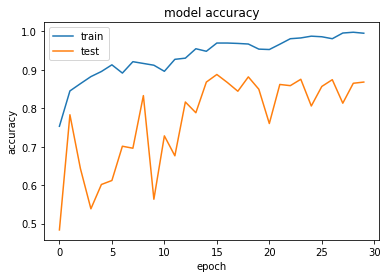

In [81]:
history = model_cnn.fit(rX_train, ry_train, validation_split=0.33, epochs=30, batch_size=batch_size, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Modele 2

In [104]:
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(input_shape=(80,80,3),filters=24,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


model_cnn2.add(Conv2D(filters=24,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(units=1000,activation="relu"))
model_cnn2.add(Dense(units=500,activation="relu"))
model_cnn2.add(Dense(units=1, activation="sigmoid"))



Epoch 1/30
31/31 [==============================] - 16s 515ms/step - loss: 1.8381 - accuracy: 0.7554 - val_loss: 0.7004 - val_accuracy: 0.4492
Epoch 2/30
31/31 [==============================] - 19s 618ms/step - loss: 0.4467 - accuracy: 0.8390 - val_loss: 1.0498 - val_accuracy: 0.4409
Epoch 3/30
31/31 [==============================] - 16s 507ms/step - loss: 0.3104 - accuracy: 0.8953 - val_loss: 1.4545 - val_accuracy: 0.4461
Epoch 4/30
31/31 [==============================] - 15s 487ms/step - loss: 0.2116 - accuracy: 0.9216 - val_loss: 2.3157 - val_accuracy: 0.4409
Epoch 5/30
31/31 [==============================] - 15s 481ms/step - loss: 0.1816 - accuracy: 0.9284 - val_loss: 2.5092 - val_accuracy: 0.4409
Epoch 6/30
31/31 [==============================] - 15s 484ms/step - loss: 0.1091 - accuracy: 0.9615 - val_loss: 2.5270 - val_accuracy: 0.4481
Epoch 7/30
31/31 [==============================] - 15s 478ms/step - loss: 0.0706 - accuracy: 0.9720 - val_loss: 3.1932 - val_accuracy: 0.4461

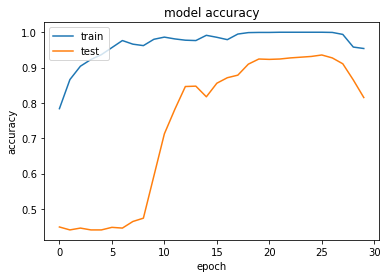

In [100]:
model_cnn2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001),metrics=["accuracy"])
history = model_cnn2.fit(rX_train, ry_train, validation_split=0.33, epochs=30, batch_size=batch_size, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Modele 3

In [105]:
like_vgg19 = Sequential()
like_vgg19.add(Conv2D(input_shape=(80,80,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
like_vgg19.add(BatchNormalization())
like_vgg19.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

like_vgg19.add(Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
like_vgg19.add(BatchNormalization())
like_vgg19.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

like_vgg19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(BatchNormalization())
like_vgg19.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(BatchNormalization())
like_vgg19.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
like_vgg19.add(BatchNormalization())
like_vgg19.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


like_vgg19.add(Flatten())
like_vgg19.add(Dense(units=4096,activation="relu"))
like_vgg19.add(Dense(units=4096,activation="relu"))
like_vgg19.add(BatchNormalization())
like_vgg19.add(Dense(units=2, activation="softmax"))

Epoch 1/10
28/28 [==============================] - 292s 10s/step - loss: 0.5587 - accuracy: 0.7735 - val_loss: 0.6992 - val_accuracy: 0.4564
Epoch 2/10
28/28 [==============================] - 306s 11s/step - loss: 0.3155 - accuracy: 0.8795 - val_loss: 0.7081 - val_accuracy: 0.4564
Epoch 3/10
28/28 [==============================] - 312s 11s/step - loss: 0.2770 - accuracy: 0.8846 - val_loss: 0.6938 - val_accuracy: 0.4564
Epoch 4/10
28/28 [==============================] - 317s 11s/step - loss: 0.2194 - accuracy: 0.9181 - val_loss: 0.6910 - val_accuracy: 0.5436
Epoch 5/10
28/28 [==============================] - 324s 12s/step - loss: 0.1585 - accuracy: 0.9408 - val_loss: 0.7197 - val_accuracy: 0.4564
Epoch 6/10
28/28 [==============================] - 346s 12s/step - loss: 0.1571 - accuracy: 0.9377 - val_loss: 0.7257 - val_accuracy: 0.4564
Epoch 7/10
28/28 [==============================] - 330s 12s/step - loss: 0.1419 - accuracy: 0.9470 - val_loss: 0.7754 - val_accuracy: 0.4564
Epoch 

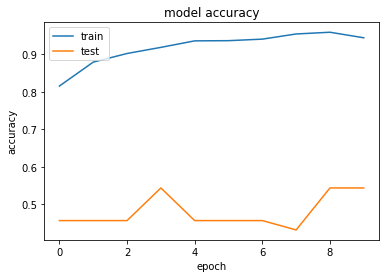

In [48]:
like_vgg19.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])


history = like_vgg19.fit(rX_train, to_categorical(ry_train), validation_split=0.33, epochs=10, batch_size=70, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

### Model 4


In [106]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
for layer in vgg19.layers[:]:
    layer.trainable = False
model4 = Sequential()
model4.add(vgg19)
model4.add(Flatten())
model4.add(Dense(1024, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])

Epoch 1/10
31/31 [==============================] - 89s 3s/step - loss: 0.5652 - accuracy: 0.7139 - val_loss: 0.3461 - val_accuracy: 0.8890
Epoch 2/10
31/31 [==============================] - 95s 3s/step - loss: 0.3481 - accuracy: 0.8782 - val_loss: 0.2890 - val_accuracy: 0.9098
Epoch 3/10
31/31 [==============================] - 100s 3s/step - loss: 0.2940 - accuracy: 0.8944 - val_loss: 0.2805 - val_accuracy: 0.8911
Epoch 4/10
31/31 [==============================] - 98s 3s/step - loss: 0.2684 - accuracy: 0.8982 - val_loss: 0.2570 - val_accuracy: 0.9035
Epoch 5/10
31/31 [==============================] - 93s 3s/step - loss: 0.2704 - accuracy: 0.8992 - val_loss: 0.2481 - val_accuracy: 0.9025
Epoch 6/10
31/31 [==============================] - 100s 3s/step - loss: 0.2349 - accuracy: 0.9157 - val_loss: 0.2364 - val_accuracy: 0.9160
Epoch 7/10
31/31 [==============================] - 102s 3s/step - loss: 0.2137 - accuracy: 0.9237 - val_loss: 0.2332 - val_accuracy: 0.9098
Epoch 8/10
31/31 

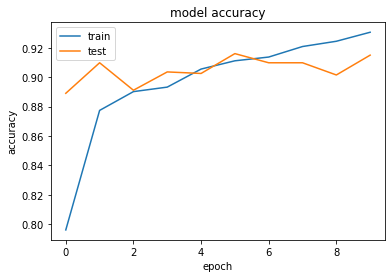

In [128]:
history = model4.fit(rX_train, ry_train, validation_split=0.33, epochs=10, batch_size=64, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

### Model 5 - MobileNet

In [139]:
model_mob = MobileNet(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
for layer in model_mob.layers[:]:
    layer.trainable = False
model5 = Sequential()
model5.add(model_mob)
model5.add(Flatten())
model5.add(Dropout(0.5))
model5.add(Dense(1024, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(1024, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])

Epoch 1/10
31/31 [==============================] - 9s 263ms/step - loss: 0.5956 - accuracy: 0.6757 - val_loss: 0.3253 - val_accuracy: 0.8817
Epoch 2/10
31/31 [==============================] - 8s 270ms/step - loss: 0.3090 - accuracy: 0.8719 - val_loss: 0.2682 - val_accuracy: 0.8859
Epoch 3/10
31/31 [==============================] - 8s 264ms/step - loss: 0.2777 - accuracy: 0.8909 - val_loss: 0.2425 - val_accuracy: 0.8942
Epoch 4/10
31/31 [==============================] - 8s 259ms/step - loss: 0.2072 - accuracy: 0.9020 - val_loss: 0.2308 - val_accuracy: 0.9129
Epoch 5/10
31/31 [==============================] - 8s 255ms/step - loss: 0.1858 - accuracy: 0.9215 - val_loss: 0.2253 - val_accuracy: 0.9149
Epoch 6/10
31/31 [==============================] - 8s 251ms/step - loss: 0.1612 - accuracy: 0.9441 - val_loss: 0.2195 - val_accuracy: 0.9108
Epoch 7/10
31/31 [==============================] - 8s 258ms/step - loss: 0.1362 - accuracy: 0.9490 - val_loss: 0.2161 - val_accuracy: 0.9180
Epoch 

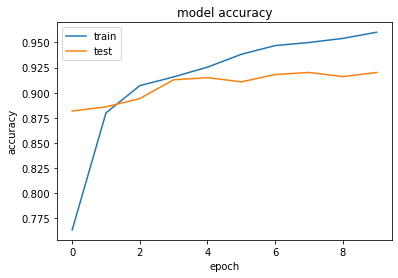

In [33]:
history = model5.fit(rX_train, ry_train, validation_split=0.33, epochs=10, batch_size=64, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## **IV.2 - Data augmentation**

In [108]:
mean = resized_train.mean(axis=0)
std = resized_train.mean(axis=0)

images_train_n = (resized_train - mean)/std
images_test_n = (resized_test - mean)/std

In [109]:
i=np.random.randint(100)
np.random.seed(i)
images_train_p =np.random.permutation(images_train_n)

np.random.seed(i)
imy_train=np.random.permutation(y_train)

np.random.seed(i)
imy_train_bis=np.random.permutation(y_train_bis)

In [111]:
aug = ImageDataGenerator(rotation_range=180, vertical_flip=True, horizontal_flip=True)
new_train = np.zeros((2*images_train_p.shape[0], images_train_p.shape[1], images_train_p.shape[2], images_train_p.shape[3]))
new_y_train = np.zeros(2*images_train_p.shape[0])
for i in range(2):
    train_aug = aug.flow(images_train_p, imy_train, batch_size=1)
    for j in range(images_train_p.shape[0]):
        new_train[i*images_train_p.shape[0]+j]=train_aug[j][0][0]
        new_y_train[i*images_train_p.shape[0]+j]=train_aug[j][1][0]
        

### Model 2

In [112]:
model_cnn2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001),metrics=["accuracy"])
history = model_cnn2.fit(new_train, new_y_train, epochs=10, batch_size=64, validation_split=0.33)

Epoch 1/10
62/62 [==============================] - 47s 690ms/step - loss: 1.3633 - accuracy: 0.7856 - val_loss: 0.6971 - val_accuracy: 0.5539
Epoch 2/10
62/62 [==============================] - 43s 690ms/step - loss: 0.3452 - accuracy: 0.8896 - val_loss: 0.8983 - val_accuracy: 0.5202
Epoch 3/10
62/62 [==============================] - 41s 664ms/step - loss: 0.2362 - accuracy: 0.9273 - val_loss: 0.5965 - val_accuracy: 0.6883
Epoch 4/10
62/62 [==============================] - 48s 781ms/step - loss: 0.1564 - accuracy: 0.9366 - val_loss: 0.6616 - val_accuracy: 0.7298
Epoch 5/10
62/62 [==============================] - 45s 728ms/step - loss: 0.1813 - accuracy: 0.9478 - val_loss: 0.5163 - val_accuracy: 0.7941
Epoch 6/10
62/62 [==============================] - 50s 803ms/step - loss: 0.0719 - accuracy: 0.9743 - val_loss: 0.8015 - val_accuracy: 0.7604
Epoch 7/10
62/62 [==============================] - 50s 809ms/step - loss: 0.0901 - accuracy: 0.9674 - val_loss: 0.4549 - val_accuracy: 0.8485

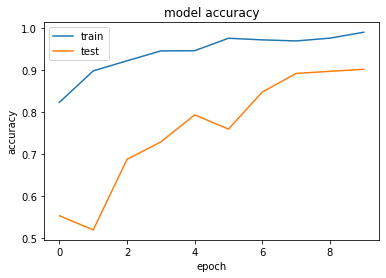

In [114]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [119]:
y_pred_CNN2 =  (model_cnn2.predict(images_test_n) > 0.5).astype("int32")

train_score_cnn2 = mcc((model_cnn2.predict(new_train) > 0.5).astype("int32"), new_y_train)

print("Mcc training score :", train_score_cnn2)
submission_CNN2 = pd.DataFrame()
submission_CNN2["ID"] = id_test
submission_CNN2["ABNORMAL"] = y_pred_CNN2

submission_CNN2.to_csv(Working_directory + "submission_cnn2.2.csv",index=False)

Mcc training score : 0.8952226932636531


C:\Users\mokar\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


Résultat : 0.77823

In [121]:
scores["CNN2"] = [train_score_cnn2, 0.77823]

### Model 4

In [122]:
model4.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])
history = model4.fit(new_train, new_y_train, epochs=5, batch_size=64, validation_split=0.25)

Epoch 1/5
69/69 [==============================] - 191s 3s/step - loss: 0.5243 - accuracy: 0.7398 - val_loss: 0.2623 - val_accuracy: 0.9192
Epoch 2/5
69/69 [==============================] - 197s 3s/step - loss: 0.2627 - accuracy: 0.9100 - val_loss: 0.2243 - val_accuracy: 0.9261
Epoch 3/5
69/69 [==============================] - 187s 3s/step - loss: 0.2218 - accuracy: 0.9252 - val_loss: 0.2069 - val_accuracy: 0.9329
Epoch 4/5
69/69 [==============================] - 172s 3s/step - loss: 0.1901 - accuracy: 0.9304 - val_loss: 0.1949 - val_accuracy: 0.9363
Epoch 5/5
69/69 [==============================] - 181s 3s/step - loss: 0.1704 - accuracy: 0.9402 - val_loss: 0.1851 - val_accuracy: 0.9370


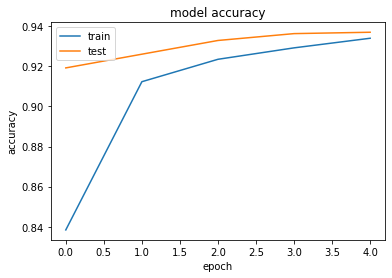

In [123]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [125]:
y_pred_model4 =  (model4.predict(images_test_n) > 0.5).astype("int32")
train_score_cnn4 = mcc((model4.predict(new_train) > 0.5).astype("int32"), new_y_train)

print("Mcc training score :", train_score_cnn4)

submission_model4 = pd.DataFrame()
submission_model4["ID"] = id_test
submission_model4["ABNORMAL"] = y_pred_model4
submission_model4.to_csv(Working_directory + "submission_model4.4.csv",index=False)

Mcc training score : 0.8760262368839964


C:\Users\mokar\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [126]:
scores["CNN4"] = [train_score_cnn4, 0.88336]

### Model 5

In [140]:
model5.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])
history = model5.fit(new_train, new_y_train , epochs=20, batch_size=65)


Epoch 1/20
90/90 [==============================] - 17s 165ms/step - loss: 0.3995 - accuracy: 0.8148
Epoch 2/20
90/90 [==============================] - 17s 191ms/step - loss: 0.2111 - accuracy: 0.9187
Epoch 3/20
90/90 [==============================] - 17s 189ms/step - loss: 0.1685 - accuracy: 0.9316
Epoch 4/20
90/90 [==============================] - 18s 197ms/step - loss: 0.1401 - accuracy: 0.9414
Epoch 5/20
90/90 [==============================] - 18s 195ms/step - loss: 0.1239 - accuracy: 0.9540
Epoch 6/20
90/90 [==============================] - 17s 193ms/step - loss: 0.1142 - accuracy: 0.9563
Epoch 7/20
90/90 [==============================] - 17s 185ms/step - loss: 0.0914 - accuracy: 0.9663
Epoch 8/20
90/90 [==============================] - 17s 187ms/step - loss: 0.0894 - accuracy: 0.9634
Epoch 9/20
90/90 [==============================] - 17s 190ms/step - loss: 0.0801 - accuracy: 0.9697
Epoch 10/20
90/90 [==============================] - 17s 187ms/step - loss: 0.0701 - accura

In [141]:
y_pred_model5 =  (model5.predict(images_test_n) > 0.5).astype("int32")
train_score_cnn5 = mcc((model5.predict(new_train) > 0.5).astype("int32"), new_y_train)

print("Mcc training score :", train_score_cnn5)

submission_model5 = pd.DataFrame()
submission_model5["ID"] = id_test
submission_model5["ABNORMAL"] = y_pred_model5
submission_model5.to_csv(Working_directory + "submission_model5.csv",index=False)

Mcc training score : 1.0


C:\Users\mokar\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


Résultat : 0.84665

In [142]:
scores["CNN5"] = [train_score_cnn5, 0.84665]

### Model 2 - Multiclass

In [14]:
aug = ImageDataGenerator(rotation_range=180, vertical_flip=True, horizontal_flip=True)
new_train_bis = np.zeros((2*images_train_p.shape[0], images_train_p.shape[1], images_train_p.shape[2], images_train_p.shape[3]))
new_y_train_bis = np.zeros(2*images_train_p.shape[0])
for i in range(2):
    train_aug = aug.flow(images_train_p, imy_train_bis, batch_size=1)
    for j in range(images_train_p.shape[0]):
        new_train_bis[i*images_train_p.shape[0]+j]=train_aug[j][0][0]
        new_y_train_bis[i*images_train_p.shape[0]+j]=train_aug[j][1][0]

In [15]:
new_y_train_bis = to_categorical(new_y_train_bis)

In [166]:
model_cnn2_bis = Sequential()
model_cnn2_bis.add(Conv2D(input_shape=(80,80,3),filters=24,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2_bis.add(BatchNormalization())
model_cnn2_bis.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


model_cnn2_bis.add(Conv2D(filters=24,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2_bis.add(BatchNormalization())
model_cnn2_bis.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2_bis.add(Conv2D(filters=24,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2_bis.add(BatchNormalization())
model_cnn2_bis.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2_bis.add(Flatten())
model_cnn2_bis.add(Dense(units=1000,activation="relu"))
model_cnn2_bis.add(Dense(units=1000,activation="relu"))
model_cnn2_bis.add(Dense(units=9, activation="softmax"))

model_cnn2_bis.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005),metrics=["accuracy"])

In [167]:
history = model_cnn2_bis.fit(train_aug_bis, epochs=20, steps_per_epoch=len(train_aug_bis), validation_data=val_aug_bis)

Epoch 1/20
22/22 [==============================] - 14s 618ms/step - loss: 1.7950 - accuracy: 0.4742 - val_loss: 2.0447 - val_accuracy: 0.2977
Epoch 2/20
22/22 [==============================] - 17s 778ms/step - loss: 0.8165 - accuracy: 0.7280 - val_loss: 1.9787 - val_accuracy: 0.3371
Epoch 3/20
22/22 [==============================] - 16s 734ms/step - loss: 0.5720 - accuracy: 0.7994 - val_loss: 2.0091 - val_accuracy: 0.3724
Epoch 4/20
22/22 [==============================] - 16s 714ms/step - loss: 0.5326 - accuracy: 0.8053 - val_loss: 2.2198 - val_accuracy: 0.3226
Epoch 5/20
22/22 [==============================] - 16s 723ms/step - loss: 0.4943 - accuracy: 0.8166 - val_loss: 2.4063 - val_accuracy: 0.3703
Epoch 6/20
22/22 [==============================] - 16s 717ms/step - loss: 0.4201 - accuracy: 0.8615 - val_loss: 2.5770 - val_accuracy: 0.3475
Epoch 7/20
22/22 [==============================] - 16s 734ms/step - loss: 0.3889 - accuracy: 0.8643 - val_loss: 2.9137 - val_accuracy: 0.3299

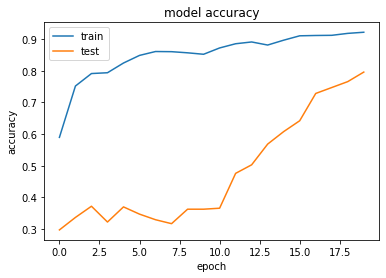

In [168]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [169]:
y_pred_CNN2_bis = np.argmax(model_cnn2_bis.predict(images_test_n), axis=-1)
submission_CNN2_bis = pd.DataFrame()
submission_CNN2_bis["ID"] = id_test
submission_CNN2_bis["GROUP"] = y_pred_CNN2_bis

submission_CNN2_bis.to_csv(Working_directory + "submission_cnn3_bis.csv",index=False)

In [127]:
scores_bis["CNN2"] = [0.9294, 0.70592]

### Model 4 - Multiclass

In [16]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
for layer in vgg19.layers[:]:
    layer.trainable = False
model4_bis = Sequential()
model4_bis.add(vgg19)
model4_bis.add(Flatten())
model4_bis.add(Dense(1024, activation='relu'))
model4_bis.add(Dense(9, activation='softmax'))

model4_bis.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=["accuracy"])

In [17]:
new_y_train_bis.shape

(5842, 9)

In [19]:
history = model4_bis.fit(new_train_bis, new_y_train_bis, epochs=5, batch_size=64, validation_split = 0.25)

Epoch 1/5
69/69 [==============================] - 165s 2s/step - loss: 1.0654 - accuracy: 0.6953 - val_loss: 0.8271 - val_accuracy: 0.7331
Epoch 2/5
69/69 [==============================] - 173s 3s/step - loss: 0.7196 - accuracy: 0.7738 - val_loss: 0.6961 - val_accuracy: 0.7652
Epoch 3/5
69/69 [==============================] - 169s 2s/step - loss: 0.6135 - accuracy: 0.8003 - val_loss: 0.6408 - val_accuracy: 0.7775
Epoch 4/5
69/69 [==============================] - 176s 3s/step - loss: 0.5482 - accuracy: 0.8181 - val_loss: 0.5950 - val_accuracy: 0.7864
Epoch 5/5
69/69 [==============================] - 183s 3s/step - loss: 0.5070 - accuracy: 0.8325 - val_loss: 0.5779 - val_accuracy: 0.7892


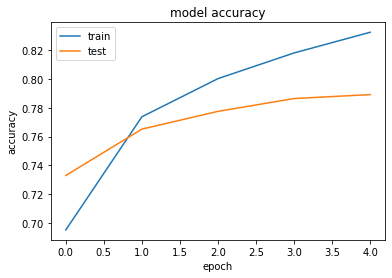

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [20]:
y_pred_model4_bis = np.argmax(model4_bis.predict(images_test_n), axis=-1)
submission_model4_bis = pd.DataFrame()
submission_model4_bis["ID"] = id_test
submission_model4_bis["GROUP"] = y_pred_model4_bis

submission_model4_bis.to_csv(Working_directory + "submission_cnn3_bis.csv",index=False)

C:\Users\mokar\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [128]:
scores_bis["CNN4"] = [0.8325, 0.64358]

# <u>V - Autres méthodes</u>
## V.1 - Deep features

In [103]:
vgg=VGG19(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
extract_model = Sequential()
extract_model.add(vgg)
extract_model.add(Flatten())

extract_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [111]:
vgg_train = extract_model.predict(rX_train)
vgg_test = extract_model.predict(resized_test)

scaler = StandardScaler()
scaler.fit(vgg_train)
vgg_train_n = scaler.transform(vgg_train)
vgg_test_n = scaler.transform(vgg_test)

In [118]:
pd.DataFrame(vgg_train_n).to_csv(Working_directory + "features_train3.csv", index=None)
pd.DataFrame(vgg_test_n).to_csv(Working_directory + "features_test3.csv", index=None)

In [119]:
pca = PCA(0.99)
pca.fit(vgg_train_n)
train_pca = pca.transform(vgg_train_n)
test_pca = pca.transform(vgg_test_n)

Epoch 1/50
31/31 [==============================] - 3s 23ms/step - loss: 0.5864 - accuracy: 0.6800 - val_loss: 0.6010 - val_accuracy: 0.7656
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.3200 - accuracy: 0.8606 - val_loss: 0.5430 - val_accuracy: 0.7822
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2472 - accuracy: 0.9074 - val_loss: 0.4688 - val_accuracy: 0.7842
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.1740 - accuracy: 0.9345 - val_loss: 0.4432 - val_accuracy: 0.7853
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.1455 - accuracy: 0.9461 - val_loss: 0.4340 - val_accuracy: 0.7863
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.1047 - accuracy: 0.9656 - val_loss: 0.4617 - val_accuracy: 0.7801
Epoch 7/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0751 - accuracy: 0.9771 - val_loss: 0.4873 - val_accuracy: 0.7873
Epoch 8/50
31/31 [

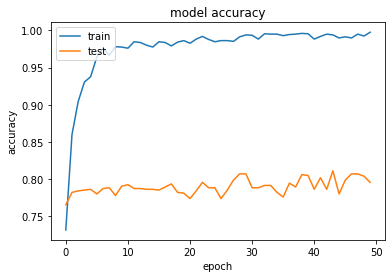

In [122]:
n_input = train_pca.shape[1]  # Number of input features
n_hidden = 150
n_hidden2 = 200
# Number of hidden nodes

# create the model (using the sequential API)

model_mlp3 = Sequential([Dense(n_hidden, input_shape=(n_input,)),
                        Activation('relu'),
                        BatchNormalization(),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        BatchNormalization(),
                        Dense(n_hidden, input_shape=(n_hidden,)),
                        Activation('relu'),
                        BatchNormalization(),
                        Dense(n_hidden2, input_shape=(n_hidden2,)),
                        Activation('relu'),
                        BatchNormalization(),
                        Dense(n_hidden2, input_shape=(n_hidden2,)),
                        Activation('relu'),
                        Dense(1, input_shape=(n_hidden2,)),
                        Activation('sigmoid')])

learning_rate = 0.001
model_mlp3.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) # TO FILL IN
batch_size = 64

history = model_mlp3.fit(train_pca, ry_train, validation_split=0.33, epochs=50, batch_size=batch_size, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
import warnings
warnings.filterwarnings("ignore")


p_grid_nlsvm = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, scoring=make_scorer(mcc), cv=5 )
grid_nlsvm.fit(train_pca, ry_train)
warnings.filterwarnings("default")
print("Best Validation score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

Best Validation score: 0.6323448710499815
Best training params: {'C': 10, 'gamma': 0.01}


## V.2 - PCA

In [256]:
train_vector = rX_train.mean(axis=-1).reshape(rX_train.shape[0],rX_train.shape[1]*rX_train.shape[2])
test_vector = resized_test.mean(axis=-1).reshape(resized_test.shape[0], resized_test.shape[1]*resized_test.shape[2])

In [257]:
pca2 = PCA(0.99)
pca2.fit(train_vector)
train_pca2 = pca2.transform(train_vector)
test_pca2 = pca2.transform(test_vector)
print(test_pca2.shape)

(1252, 163)


In [259]:
warnings.filterwarnings("ignore")
p_grid_nlsvm = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, scoring=make_scorer(mcc), cv=5 )
grid_nlsvm.fit(train_pca2, ry_train)
print("Best Validation score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
warnings.filterwarnings("default")

Best Validation score: 0.6758547739370676
Best training params: {'C': 1, 'gamma': 0.01}


## V.3 - Somme des résultats


In [244]:
y1 = to_categorical(pd.read_csv(Working_directory +"submission_model4.4.csv")["ABNORMAL"])
y2 = to_categorical(pd.read_csv(Working_directory +"submission_model4.3.csv")["ABNORMAL"])
y3 = to_categorical(pd.read_csv(Working_directory +"submission_cnn3.csv")["ABNORMAL"])
y4 = to_categorical(pd.read_csv(Working_directory +"submission_mlp.csv")["ABNORMAL"])
y5 = to_categorical(pd.read_csv(Working_directory +"submission_nlsvm2.csv")["ABNORMAL"])

y_sum = np.argmax((y1 + y2 + y3 + y4 + y5), axis=-1)

submission_sum = pd.DataFrame()
submission_sum["ID"] = id_test
submission_sum["ABNORMAL"] = y_sum

submission_sum.to_csv(Working_directory + "submission_sum.csv",index=False)

Résultat : 0.91221

In [148]:
scores["sum"] = [np.nan, 0.91221]

In [23]:
y1 = to_categorical(pd.read_csv(Working_directory +"submission_model4.4.csv")["ABNORMAL"])
y2 = to_categorical(pd.read_csv(Working_directory +"submission_model4.3.csv")["ABNORMAL"])
y3 = to_categorical(pd.read_csv(Working_directory +"submission_cnn3.csv")["ABNORMAL"])
y4 = to_categorical(pd.read_csv(Working_directory +"submission_mlp.csv")["ABNORMAL"])
y5 = to_categorical(pd.read_csv(Working_directory +"submission_nlsvm2.csv")["ABNORMAL"])
y6 = to_categorical(pd.read_csv(Working_directory +"submission_RF2.2.csv")["ABNORMAL"])
y7 = to_categorical(pd.read_csv(Working_directory +"submission_Ada_cv2.3.csv")["ABNORMAL"])
y8 = to_categorical(pd.read_csv(Working_directory +"submission_mlp2.csv")["ABNORMAL"])
y9 = to_categorical(pd.read_csv(Working_directory +"submission_cnn4.csv")["ABNORMAL"])
y10 = to_categorical(pd.read_csv(Working_directory +"submission_model4.csv")["ABNORMAL"])

y_sum2 = np.argmax((y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9 + y10), axis=-1)

submission_sum2 = pd.DataFrame()
submission_sum2["ID"] = id_test
submission_sum2["ABNORMAL"] = y_sum2

submission_sum2.to_csv(Working_directory + "submission_sum2.csv",index=False)


Résultat : 0.92350

In [149]:
scores["sum2"] = [np.nan, 0.92350]

Multiclass:


In [26]:
y1_bis = to_categorical(pd.read_csv(Working_directory +"submission_ovr2.csv")["GROUP"])
y2_bis = to_categorical(pd.read_csv(Working_directory +"submission_RF_bis2.2csv")["GROUP"])
y3_bis = to_categorical(pd.read_csv(Working_directory +"submission_mlp_bis2.csv")["GROUP"])
y4_bis = to_categorical(pd.read_csv(Working_directory +"submission_mlp_bis.csv")["GROUP"])
y5_bis = to_categorical(pd.read_csv(Working_directory +"submission_RF_bis2.csv")["GROUP"])

y_sum_bis = np.argmax((y1_bis + y2_bis + y3_bis + y4_bis + y5_bis), axis=-1)

submission_sum_bis = pd.DataFrame()
submission_sum_bis["ID"] = id_test
submission_sum_bis["GROUP"] = y_sum_bis

submission_sum_bis.to_csv(Working_directory + "submission_sum_bis.csv",index=False)

In [150]:
scores_bis["sum"] = [np.nan, 0.67876]

Résultat :  0.67876

# VI - Conclusion

In [151]:
scores.to_csv(Working_directory + "scores.csv")

In [152]:
scores_bis.to_csv(Working_directory + "scores_bis.csv")

In [157]:
scores

,LDA,QDA,KNN,LSVM,NLSVM,NLSVM2,RF2,AdaBoost2,MLP,MLP2,CNN2,CNN4,CNN5,sum,sum2
Train,0.798283,0.696799,0.84344,0.838846,0.842674,0.965375,0.993077,0.939798,0.992811,0.955669,0.895223,0.876026,1.00000,NaN,NaN
Test,0.777810,0.653390,0.73830,0.756630,0.810230,0.808840,0.801210,0.786340,0.846770,0.846350,0.778230,0.883360,0.84665,0.91221,0.9235


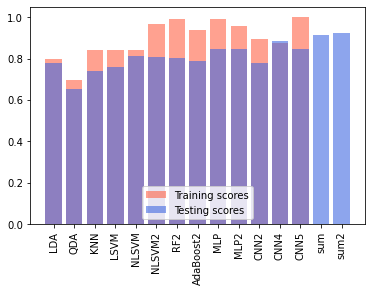

In [160]:
plt.bar(scores.columns, scores.iloc[0],color="tomato", label="Training scores", alpha=0.6)
plt.bar(scores.columns, scores.iloc[1],color="royalblue", label="Testing scores", alpha=0.6)
plt.legend(loc='lower center')
plt.xticks(scores.columns,  rotation=90)
plt.show()

In [158]:
scores_bis

,LDA,QDA,KNN,LDA2,SVM_OvR_2,RF2,MLP,MLP2,CNN2,CNN4,sum
Train,0.680676,0.727094,0.72039,0.723998,0.83768,0.997679,0.995892,1.0000,0.92940,0.83250,NaN
Test,0.599870,0.513790,0.51379,0.706840,0.69823,0.671710,0.668700,0.6687,0.70592,0.64358,0.67876


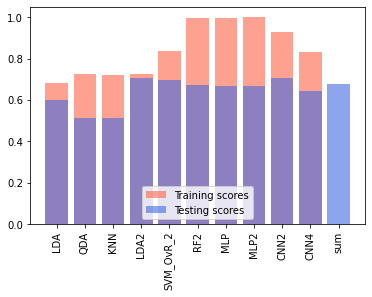

In [161]:
plt.bar(scores_bis.columns, scores_bis.iloc[0],color="tomato", label="Training scores", alpha=0.6)
plt.bar(scores_bis.columns, scores_bis.iloc[1],color="royalblue", label="Testing scores", alpha=0.6)
plt.legend(loc='lower center')
plt.xticks(scores_bis.columns,  rotation=90)
plt.show()